Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
# drive.mount('/content/gdrive')
drive.mount('/content/gdrive', force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Training set:',image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Test set:',image_count_test)

Training set: 2239
Test set: 118


In [ ]:
# Checking the number of GPUs available
def gpu_check():
  physical_devices = tf.config.list_physical_devices('GPU')
  print("Num of currently available GPUs:", len(physical_devices))

gpu_check()

Num of currently available GPUs: 1


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
help(tf.keras.preprocessing.image_dataset_from_directory)

Help on function image_dataset_from_directory in module keras.src.utils.image_dataset_utils:

image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, pad_to_aspect_ratio=False, data_format=None, verbose=True)
    Generates a `tf.data.Dataset` from image files in a directory.
    
    If your directory structure is:
    
    ```
    main_directory/
    ...class_a/
    ......a_image_1.jpg
    ......a_image_2.jpg
    ...class_b/
    ......b_image_1.jpg
    ......b_image_2.jpg
    ```
    
    Then calling `image_dataset_from_directory(main_directory,
    labels='inferred')` will return a `tf.data.Dataset` that yields batches of
    images from the subdirectories `class_a` and `class_b`, together with labels
    0 and 1 (0 corresponding to `class_a` and 1 correspo

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds =  tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            seed=123,
            validation_split=0.2,
            subset='training',
            image_size=(img_height, img_width),
            batch_size=batch_size
            ) ##todo

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


### Breaking down the above code block:

<pre>

  > tf.keras.preprocessing.image_dataset_from_directory(): This function is used to load the dataset of images from the directory structure. The images are organized in subdirectories corresponding to their labels(classes).

  > data_dir_train: Path to the directory containing images. Each subdirectory (e.g., actinic keratosis, basal cell carcinoma ... ) represents a class label.

  > seed=123: Using same seed ensures that the same images are selected for the training or validation subsets each time the code is run.

  > validation_split=0.2: Specifies that 20% of the total images in the Train subdirectory be reserved for validation.

  > subset='training': Indicates that this dataset is for Training subset.

  > image_size=(img_height, img_width): Resizes all the images to the specified dimensions while loading them.

  > batch_size=batch_size: A batch is a group of images that will be processed together during training to improve computational efficiency.

</pre>

### The resulting dataset is stored in train_ds and each element is a tuple (batch_images, batch_labels):
  - batch_images: Batch of image tensors.
  - batch_labels: The corresponding class labels for the images.

In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =  tf.keras.preprocessing.image_dataset_from_directory(
          data_dir_train,
          seed=123,
          validation_split=0.2,
          subset='validation',
          image_size=(img_height, img_width),
          batch_size=batch_size
          ) ##todo

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

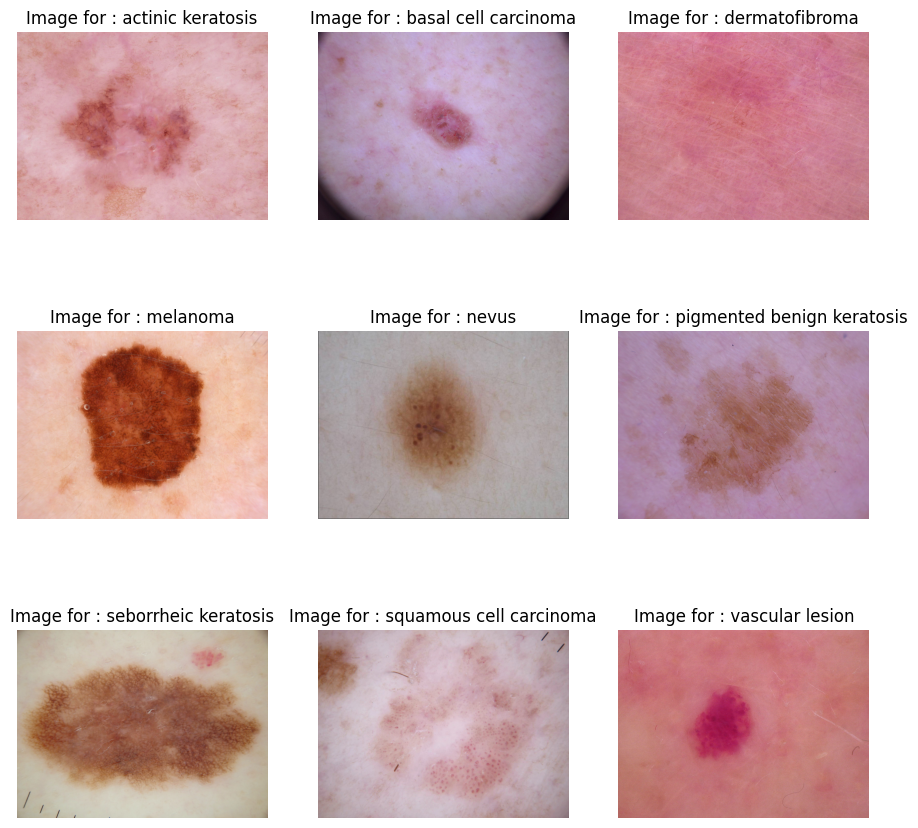

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(11,11))
for i in range(9):
  plt.subplot(3,3,i+1)
  image=plt.imread(
                    str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[2])
                  )
  plt.imshow(image)
  plt.axis('off')
  plt.title(f'Image for : {class_names[i]}')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Explanation of above code:

###### This code block optimizes the data pipeline for training and validation datasets in Tensorflow using techniques like caching, shuffling and prefetching.

<pre>
  > tf.data.experimental.AUTOTUNE: ==>
    AUTOTUNE is a value that allows Tensorflow to automatically determine the optimal value of the buffer_size in prefetch(), depending on the available resources to maximize throughput.

  > train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE): ==>
  
    ".cache()" - Caches the datasets in memory or disk to avoid repeated computation during training. Post caching, data is loaded only once, speeding up the subsequent epochs.
    ".shuffle(1000)" - determines how many elements are loaded in memory for shuffling. Here it is randomly shuffling the dataset with the buffer size of 1000 elements. This helps in avoiding the model to learn unintended patterns based on the data order.
    "prefetch(buffer_size=AUTOTUNE)" - this helps in prefecting the next batch of data while the current one is being processed by the model.

  > val_ds.cache().prefetch(buffer_size=AUTOTUNE): ==>
    The validation dataset here is cached using ".cache()" for faster evaluation, as it doesn't change during training.
    

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
help(layers.Rescaling)

Help on class Rescaling in module keras.src.layers.preprocessing.rescaling:

class Rescaling(keras.src.layers.preprocessing.tf_data_layer.TFDataLayer)
 |  Rescaling(scale, offset=0.0, **kwargs)
 |  
 |  A preprocessing layer which rescales input values to a new range.
 |  
 |  This layer rescales every value of an input (often an image) by multiplying
 |  by `scale` and adding `offset`.
 |  
 |  For instance:
 |  
 |  1. To rescale an input in the `[0, 255]` range
 |  to be in the `[0, 1]` range, you would pass `scale=1./255`.
 |  
 |  2. To rescale an input in the `[0, 255]` range to be in the `[-1, 1]` range,
 |  you would pass `scale=1./127.5, offset=-1`.
 |  
 |  The rescaling is applied both during training and inference. Inputs can be
 |  of integer or floating point dtype, and by default the layer will output
 |  floats.
 |  
 |  **Note:** This layer is safe to use inside a `tf.data` pipeline
 |  (independently of which backend you're using).
 |  
 |  Args:
 |      scale: Float,

In [ ]:
### Your code goes here

model = Sequential()
model.add(Input(shape=(img_height, img_width, 3))) # Add an Input layer
model.add(Rescaling(scale=1./255)) # Add the Rescaling layer , default offset=0.0

# Conv Block 1
model.add(Conv2D(32, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv Block 2
model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv Block 3
model.add(Conv2D(128, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv Block 4
model.add(Conv2D(256, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv Block 5
model.add(Conv2D(512, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Dense Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(len(class_names), activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
help(ReduceLROnPlateau)

Help on class ReduceLROnPlateau in module keras.src.callbacks.reduce_lr_on_plateau:

class ReduceLROnPlateau(keras.src.callbacks.callback.Callback)
 |  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0, **kwargs)
 |  
 |  Reduce learning rate when a metric has stopped improving.
 |  
 |  Models often benefit from reducing the learning rate by a factor
 |  of 2-10 once learning stagnates. This callback monitors a
 |  quantity and if no improvement is seen for a 'patience' number
 |  of epochs, the learning rate is reduced.
 |  
 |  Example:
 |  
 |  ```python
 |  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
 |                                patience=5, min_lr=0.001)
 |  model.fit(x_train, y_train, callbacks=[reduce_lr])
 |  ```
 |  
 |  Args:
 |      monitor: String. Quantity to be monitored.
 |      factor: Float. Factor by which the learning rate will be reduced.
 |          `new_lr = lr * f

In [ ]:
### Todo, choose an appropirate optimiser and loss function

learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  factor=0.2, min_lr=1e-7, verbose=1)   # monitor -> monitors the validation accuracy to decide on reducing the
                                                                        # learning rate.
                                                                        # patience -> specifies how many epochs without improvment to wait before
                                                                        # reducing the learning rate
                                                                        # factor -> multiplier for reducing the learning rate
                                                                        # (new_lr = current_lr * factor)
                                                                        # min_lr -> specifies the minimum learning rate the optimizer can reach


optmzr = tf.keras.optimizers.Adam()

model.compile(optimizer=optmzr,
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # SparseCategoricalCrossentropy -> this loss function is used for multi-class classification problems
                                    # where the target labels are inter-encoded (not one-hot encoded). It computes the cross entropy loss
                                    # between the predicted probabilities and true labels.
                                    # metrics -> specifies the metric to track during training and evaluation. Here Accuracy measures the
                                    # percentage of correct predictions



### Why use ReduceLROnPlateau?

ReduceLROnPlateau is a callback in Keras used to dynamically reduce the learning rate when a metric (like validation accuracy) stops improving.

<pre>
  Unlike the "Adam" optimizer, "ReduceLROnPlateau", reduces the entire learning rate globally for all parameters. This happens when the monitored metric (e.g. accuracy) stalls or plateaus, indicating that the optimizer may need smaller steps to continue improving.

  Adam's adjustments are based on gradient, whereas ReduceLROnPlateau adjustments are based on validation metrics (e.g. val_loss, val_accuracy)

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,737,929 (6.63 MB)

 Trainable params: 1,735,945 (6.62 MB)

 Non-trainable params: 1,984 (7.75 KB)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.2293 - loss: 2.7170 - val_accuracy: 0.1499 - val_loss: 2.2086 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.3357 - loss: 1.8940 - val_accuracy: 0.2461 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3841 - loss: 1.7436 - val_accuracy: 0.1499 - val_loss: 2.5135 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.3909 - loss: 1.7294 - val_accuracy: 0.2058 - val_loss: 2.5958 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3854 - loss: 1.7153 - val_accuracy: 0.1969 - val_loss: 2.2589 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4000 - loss: 1.6577 - val_accuracy: 0.2304 - val_loss: 2.2442 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4302 - loss: 1.5976 - val_ac

### Visualizing training results

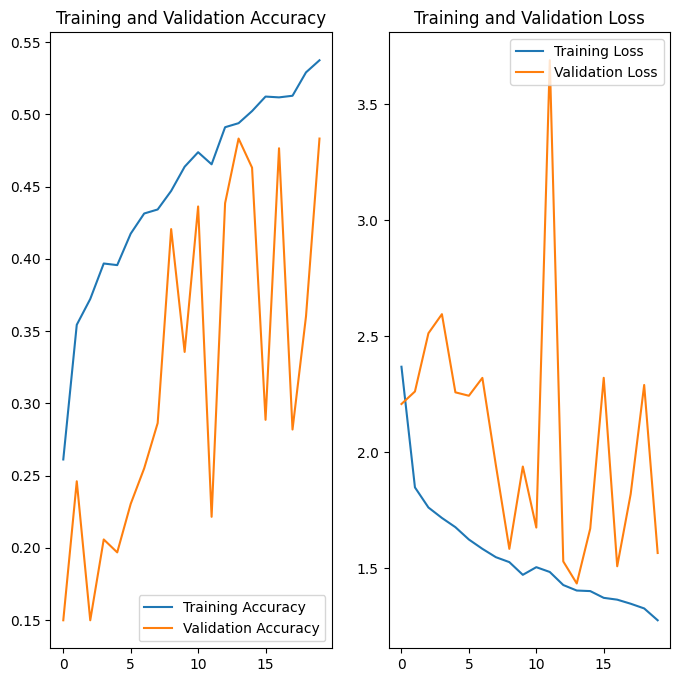

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Findings from the above model:-

After training the CNN model for 20 epochs, the following key results were observed during the final epoch:



*   Training Accuracy: 53%
*   Validation Accuracy: 48%
*   Training Loss: 1.3
*   Validation Loss: 1.5

  1. The current model shows signs of overfitting due to the accuracy and loss gaps between training and validation data.
  2. The low overall performance (training accuracy of 52%) also suggests potential underfitting.
  3. Needed adjustments to the architecture, regularization, and training schedule are recommended to improve the model's performance and generalization.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augumentation = tf.keras.Sequential(
    [
      tf.keras.layers.Input(shape=(img_height,img_width,3)),
      layers.RandomFlip('horizontal_and_vertical'),
      layers.RandomRotation(0.2),
      layers.RandomZoom(0.2),
      layers.RandomContrast(0.1),
      layers.RandomBrightness(0.2)
    ]
)

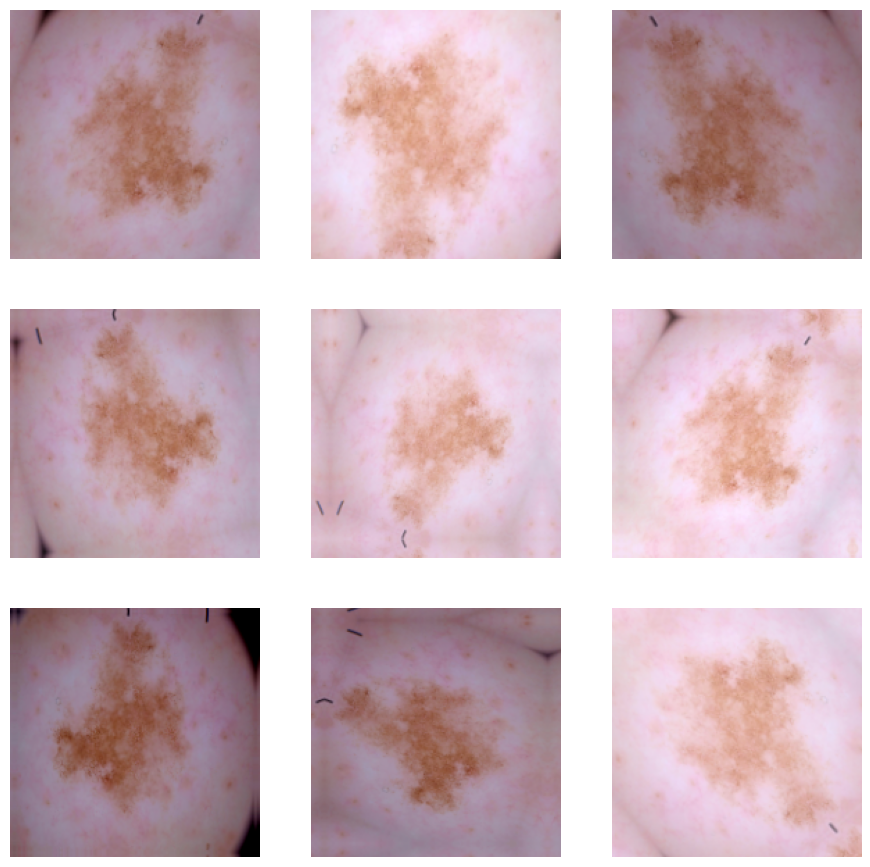

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(11,11))
for images, _ in train_ds.take(1):
  for i in range(9):
    augumented_images = data_augumentation(images)
    ax = plt.subplot(3,3, i+1)
    plt.imshow(augumented_images[0].numpy().astype('uint8'))
    plt.axis('off')

In [ ]:
#checking the shape and size of the batch and images:
images.shape

TensorShape([32, 180, 180, 3])


### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential()

model.add(Input(shape=(img_height, img_width, 3))) # Add an Input layer

model.add(Rescaling(scale=1./255)) # Add the Rescaling layer , default offset=0.0
model.add(data_augumentation) # Data Augmentation

# Conv Block 1
model.add(Conv2D(32, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv Block 2
model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv Block 3
model.add(Conv2D(128, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv Block 4
model.add(Conv2D(256, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv Block 5
model.add(Conv2D(512, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Dense Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(len(class_names), activation='softmax'))

### Compiling the model

In [ ]:
## Your code goes here
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  factor=0.2, min_lr=1e-7, verbose=1)

optmzr = tf.keras.optimizers.Adam()

model.compile(optimizer=optmzr,
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,737,929 (6.63 MB)

 Trainable params: 1,735,945 (6.62 MB)

 Non-trainable params: 1,984 (7.75 KB)

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
# epochs already declared as 20 earlier
history = model.fit(
          train_ds,
          validation_data=val_ds,
          epochs=epochs,
          callbacks=[learn_control]
)## your training code

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.1452 - loss: 2.8123 - val_accuracy: 0.2058 - val_loss: 2.0557 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.1803 - loss: 2.1808 - val_accuracy: 0.1924 - val_loss: 2.0476 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.1995 - loss: 2.1173 - val_accuracy: 0.1924 - val_loss: 2.0412 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.1759 - loss: 2.1065 - val_accuracy: 0.2058 - val_loss: 2.0402 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.1954 - loss: 2.0807 - val_accuracy: 0.1924 - val_loss: 2.0425 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2112 - loss: 2.0634
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.2110 - loss: 2.0636 

### Visualizing the results

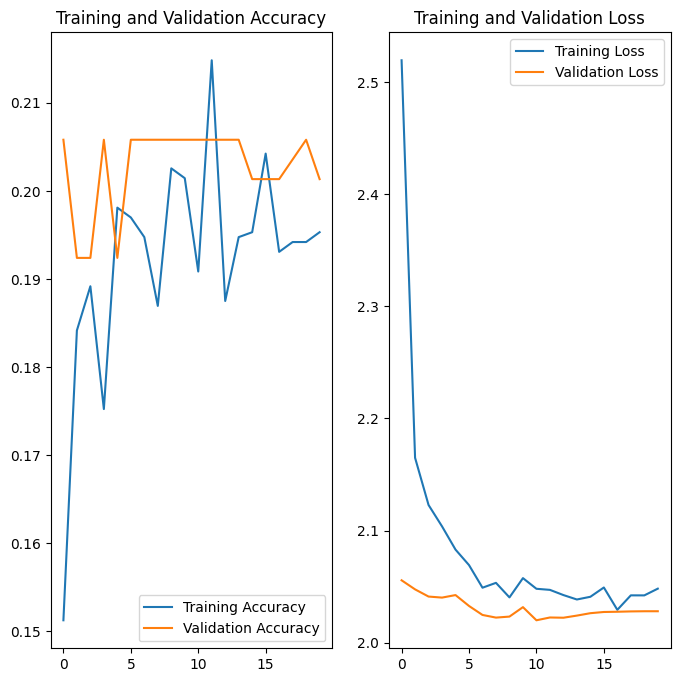

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

  *   The training accuracy (21.02%) and validation accuracy (20.13%) are both very low, close to random guessing for a multi-class classification problem. This indicates the model is severely underfitting and failing to learn meaningful patterns from the data.
  *   The augmentation pipeline (which includes RandomFlip, RandomRotation, RandomZoom, RandomContrast, and RandomBrightness) introduces variability in the training data but might be too aggressive. This could make it harder for the model to learn effectively, especially with limited epochs or an insufficiently complex architecture.
  *   There is no significant improvement in accuracy compared to the previous model runs. The aggressive augmentation pipeline combined with a potentially underpowered model architecture may have hindered learning, resulting in similar or worse performance.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.

original_df = pd.DataFrame({
    'class': class_names,
    'number': [len(list(data_dir_train.glob(f'{class_name}/*.jpg'))) for class_name in class_names]
})

original_df.sort_values(by='number')

,class,number
6,seborrheic keratosis,77
2,dermatofibroma,95
0,actinic keratosis,114
8,vascular lesion,139
7,squamous cell carcinoma,181
4,nevus,357
1,basal cell carcinoma,376
3,melanoma,438
5,pigmented benign keratosis,462


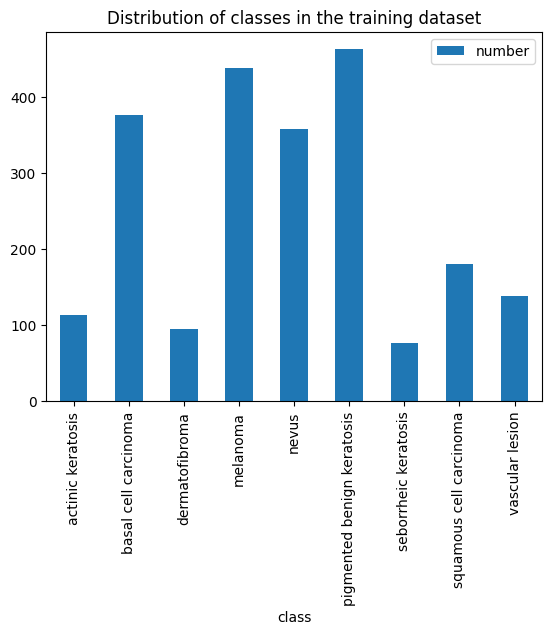

In [ ]:
original_df.plot.bar(x='class', y='number', rot=90)
plt.title('Distribution of classes in the training dataset')
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Ans. seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
#### - Ans. pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
train_dt_pth = data_dir_train.as_posix() # fetching the training set path from the already declared variable
path_to_training_dataset=train_dt_pth + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline( path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AEEFF865E10>: 100%|██████████| 500/500 [00:27<00:00, 18.33 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AEE6E76ACE0>: 100%|██████████| 500/500 [00:19<00:00, 25.85 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AEE72F5F6A0>: 100%|██████████| 500/500 [00:20<00:00, 24.86 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7AEE6E7A6E60>: 100%|██████████| 500/500 [01:38<00:00,  5.08 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=959x723 at 0x7AEE8020AFE0>: 100%|██████████| 500/500 [01:21<00:00,  6.12 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AEEFF864160>: 100%|██████████| 500/500 [00:20<00:00, 24.04 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7AEE72E08A30>: 100%|██████████| 500/500 [00:39<00:00, 12.53 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AEE801B52D0>: 100%|██████████| 500/500 [00:20<00:00, 24.59 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AEE728D8CD0>: 100%|██████████| 500/500 [00:20<00:00, 24.88 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/nevus/output/nevus_original_ISIC_0000496.jpg_8a268828-be8c-4629-80f3-67b186e00d90.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/nevus/output/nevus_original_ISIC_0000458.jpg_27523065-54c0-4b3e-a841-db735af0109e.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/nevus/output/nevus_original_ISIC_0000023.jpg_c7224011-5e3f-4d58-b0fe-66d0643ed385.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/nevus/output/nevus_original_ISIC_0000436.jpg_d4e34e37-4492-421b-8074-8f99701866d4.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/nevus/output/nevus_original_ISIC_0024948.jpg_86126646-0340-4372-8b4e-3d71ee87b28d.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/nevus/ou

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
path_list[0]

'/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/nevus/output/nevus_original_ISIC_0000496.jpg_8a268828-be8c-4629-80f3-67b186e00d90.jpg'

In [ ]:
lesion_list_new[0]

'nevus'

In [ ]:
# dict(zip(path_list[0], lesion_list_new[0]))
path_list[0], lesion_list_new[0]

('/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/nevus/output/nevus_original_ISIC_0000496.jpg_8a268828-be8c-4629-80f3-67b186e00d90.jpg',
 'nevus')

In [ ]:
# Viewing the items from the dict variable for understanding
# dataframe_dict_new.items()
list(dataframe_dict_new.items())[:3]

[('/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/nevus/output/nevus_original_ISIC_0000496.jpg_8a268828-be8c-4629-80f3-67b186e00d90.jpg',
  'nevus'),
 ('/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/nevus/output/nevus_original_ISIC_0000458.jpg_27523065-54c0-4b3e-a841-db735af0109e.jpg',
  'nevus'),
 ('/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train/nevus/output/nevus_original_ISIC_0000023.jpg_c7224011-5e3f-4d58-b0fe-66d0643ed385.jpg',
  'nevus')]

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = class_diff.append(df2)
new_df = pd.concat([original_df, df2], ignore_index=True)

In [ ]:
new_df.head()

,class,number,Path,Label
0,actinic keratosis,114.0,NaN,NaN
1,basal cell carcinoma,376.0,NaN,NaN
2,dermatofibroma,95.0,NaN,NaN
3,melanoma,438.0,NaN,NaN
4,nevus,357.0,NaN,NaN


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Path    4500 non-null   object
 1   Label   4500 non-null   object
dtypes: object(2)
memory usage: 70.4+ KB


In [ ]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   9 non-null      object
 1   number  9 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 272.0+ bytes


In [ ]:
new_df['Label'].value_counts()

,count
Label,
nevus,500
basal cell carcinoma,500
melanoma,500
squamous cell carcinoma,500
pigmented benign keratosis,500
seborrheic keratosis,500
actinic keratosis,500
vascular lesion,500
dermatofibroma,500


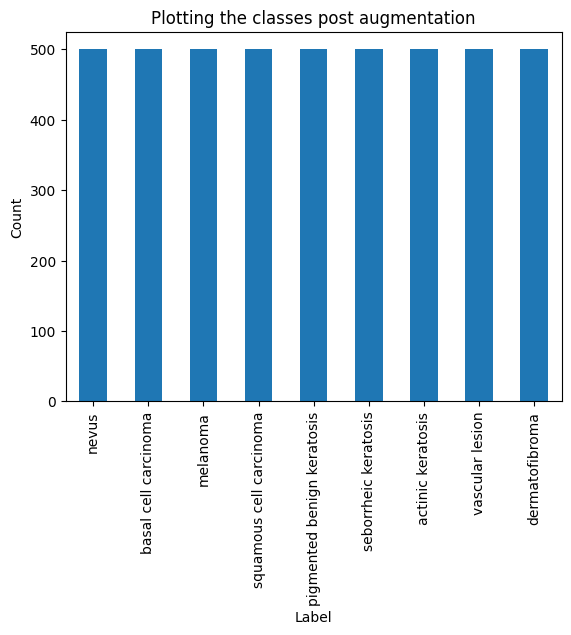

In [ ]:
new_df['Label'].value_counts().plot.bar()
plt.title('Plotting the classes post augmentation')
plt.ylabel('Count')
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
# Verfying the presence of augmented images
from pathlib import Path
base_train_dir = Path("/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/CNN/ISIC_Data/Train")
len(list(base_train_dir.glob("**/*.jpg")))

6739

In [ ]:
# Verfying the presence of augmented images using pre-declared variables
len(glob(f"{data_dir_train}/**/*.jpg", recursive=True))

6739

In [ ]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

model = Sequential()
model.add(Input(shape=(img_height, img_width, 3))) # Add an Input layer
model.add(Rescaling(scale=1./255)) # Add the Rescaling layer , default offset=0.0

# Conv Block 1
model.add(Conv2D(32, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv Block 2
model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv Block 3
model.add(Conv2D(128, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv Block 4
model.add(Conv2D(256, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv Block 5
model.add(Conv2D(512, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Dense Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(len(class_names), activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  factor=0.2, min_lr=1e-7, verbose=1)

optmzr = tf.keras.optimizers.Adam()

model.compile(optimizer=optmzr,
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,737,929 (6.63 MB)

 Trainable params: 1,735,945 (6.62 MB)

 Non-trainable params: 1,984 (7.75 KB)

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
          train_ds,
          validation_data=val_ds,
          epochs=epochs,
          callbacks=[learn_control]
)# your model fit code

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 307ms/step - accuracy: 0.2360 - loss: 2.4615 - val_accuracy: 0.1403 - val_loss: 2.5684 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 68s 260ms/step - accuracy: 0.3469 - loss: 1.7412 - val_accuracy: 0.1923 - val_loss: 2.7763 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 254ms/step - accuracy: 0.3729 - loss: 1.6376 - val_accuracy: 0.2405 - val_loss: 2.3493 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 259ms/step - accuracy: 0.4094 - loss: 1.5579 - val_accuracy: 0.3200 - val_loss: 1.9529 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 239ms/step - accuracy: 0.4163 - loss: 1.5095 - val_accuracy: 0.4284 - val_loss: 1.5270 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 262ms/step - accuracy: 0.4435 - loss: 1.4606 - val_accuracy: 0.2012 - val_loss: 3.4226 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 253ms/step - accuracy: 0.4

#### **Todo:**  Visualize the model results

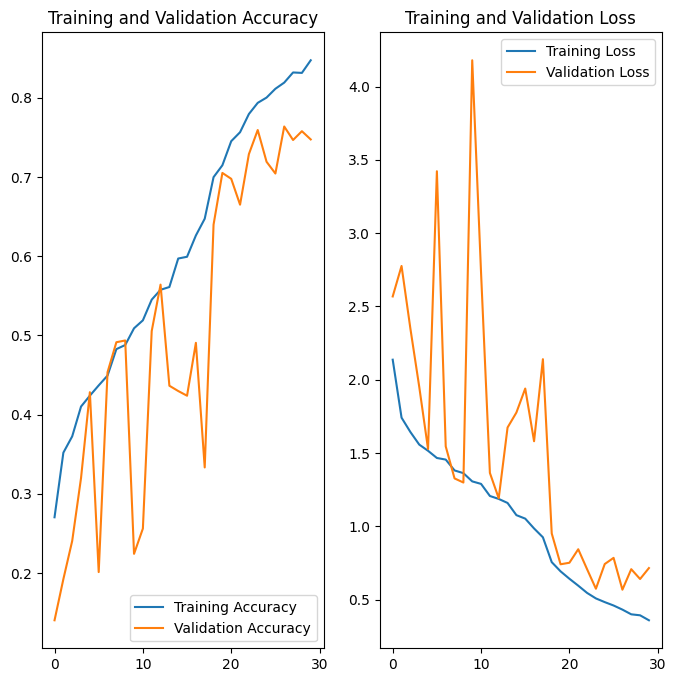

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Analysis of Results

<pre>
After implementing class rebalancing using Augmentor and training the CNN model for 30 epochs, the following results were obtained:

  *   Training Accuracy: 84.06%
  *   Training Loss: 0.3719
  *   Validation Accuracy: 74.76%
  *   Validation Loss: 0.7152
  *   Learning Rate: 2.0000e-04

Underfitting
  Definition: Underfitting occurs when the model fails to capture the underlying patterns in the training data.
Observation:
  - The high training accuracy (84.06%) indicates that the model has successfully learned patterns from the training data.
  - This suggests that underfitting has been addressed effectively.

Overfitting
  Definition: Overfitting occurs when the model performs significantly better on training data than on validation data, indicating poor generalization.
Observation:
  - The gap between training accuracy (84.06%) and validation accuracy (74.76%) is moderate (~9.3%).
  - The difference between training loss (0.3719) and validation loss (0.7152) also suggests some overfitting.
  - However, the overfitting is not severe, as the validation accuracy is relatively close to the training accuracy.

Impact of Class Rebalancing
  Class rebalancing using Augmentor helped address the issue of class imbalance by generating synthetic samples to equalize the representation of all classes.
Effect:
  - Improved the training process by preventing the model from being biased toward the majority classes.
  Likely contributed to better overall accuracy and generalization.
  - Validation accuracy (~74.76%) suggests that the model is now better at predicting minority classes, as class imbalance often leads to low validation performance.

</pre>

### Validating over Test set

In [ ]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
Test_image_path = (data_dir_test / class_names[3] / '*').as_posix()
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class :"+ class_names[3] +'\n'+ "Predictive Class :"+pred_class )

# Failed to save the plot in this notebook due to exhaustion of computational resources.

### Predicted the Melanoma case accurately:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


Actual Class melanoma

Predictive Class melanoma